# Quantum clustering: the q-means algorithm on the MNIST dataset.

In this notebook we study the performances of Q-means algorithm on the MNIST dataset. Specifically, since q-means reduces to the classical algorithm $\delta$-k-means we just tested the performance of $\delta$-k-means for various values of $\delta$.

In [1]:
%matplotlib inline

import sys
import itertools
import random
from time import time

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import matplotlib as mpl
mpl.rcParams["figure.facecolor"]= "w"
mpl.rcParams["axes.facecolor"] = "w"

import seaborn as sns; sns.set()  # for plot styling

import numpy as np

from scipy.stats import mode

import sklearn as sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import pairwise_distances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DMeans

from mnist import MNIST

import importlib
importlib.reload(sk)

from sklearn import datasets
digits = datasets.load_digits()

np.warnings.filterwarnings('ignore')

We load the data from a specific path. You might set this path to where you downloaded the dataset of MNIST. 
We want to test our images both on dimensionality reduced data and the original data, so we keep the two dataset in X and X_origin.

In [2]:
mndata = MNIST('/home/scinawa/workspace/hackedkit/python-mnist/data')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()

X_train, y_train = np.array(X_train), np.array(y_train)
X_test,  y_test  = np.array(X_test),  np.array(y_test)

#### Some helper functions

In [3]:
def find_labels(predicted, correct):
    labels_regular = np.zeros_like(correct)
    correct = np.array(correct)
    for i in np.unique(correct):        
        mask = (predicted == i)
        labels_regular[mask] = mode(correct[mask])[0]
    return labels_regular


def accuracy_kmeans(X, n_cluster, iteration_number, X_test, y_test, rseed):
    kmeans = KMeans(n_clusters=n_cluster, random_state=rseed, n_init=1, max_iter=iteration_number).fit(X)
    
    predicted_ = kmeans.predict(X_test)
    labels = find_labels(predicted_, y_test)
    
    accuracy = accuracy_score(np.array(y_test), labels)
    return accuracy

def accuracy_dmeans(X, n_cluster, iteration_number, X_test, y_test, delta, rseed):
    dmeans = DMeans(n_clusters=n_cluster, random_state=rseed, n_init=1, max_iter=iteration_number, delta=delta).fit(X)
     
    predicted_ = dmeans.predict(X_test)
    labels = find_labels(predicted_, y_test)
    
    accuracy = accuracy_score(np.array(y_test), labels)
    return accuracy

Now you can choose which dimensionality reduction algorithm to apply. We picked LDA because it gives higher accuracy and because there is a quantum algorithm for projecting the data in the same subspace (Quantum Slow Feature Analysis). You can even normalize the dataset, but we discourage this practice since it brings down the accuracy. Here we chosed LinearDisciminantAnalysis, but you can use other dr algorithms too..

In [4]:
# Avoid this for improved accuracy.
#X_train = sk.preprocessing.normalize(X_train)

# Not optimal since on supervised information performs better
#dimred = PCA(n_components=35)
dimred = LinearDiscriminantAnalysis()

X_train_dr_ = dimred.fit_transform(X_train, y_train)
X_test_dr_ = dimred.transform(X_test)

### Making the minimum norm equal to 1

We can skip this step if we think we don't need to comply to this assumption in real data analysis on a quantum computer.

In [5]:
norms = np.linalg.norm(X_train_dr_, axis=1)
print("a norm: {}".format(np.linalg.norm(X_train_dr_[0])))
print("The biggest norm before normalization is {}".format(max(norms)))
print("The smallest norm is {}".format(min(norms)))

X_train_dr = np.apply_along_axis(np.divide, 1, X_train_dr_, min(norms))
X_test_dr = np.apply_along_axis(np.divide, 1, X_test_dr_, min(norms))
norms = np.linalg.norm(X_train_dr, axis=1)
print("The biggest norm after normalization is {}".format(max(norms)))

a norm: 5.011084931661482
The biggest norm before normalization is 12.287669793890952
The smallest norm is 0.8025615543293527
The biggest norm after normalization is 15.310563691477771


### Testing that kmeans gives good accuracy.

In [6]:
kmeans = KMeans(n_clusters=10).fit(X_train)
predicted_= kmeans.predict(X_test)
labels_origin = find_labels(predicted_, y_test)

print("The accuracy of k-means before DR is {:.3}%".format(accuracy_score(y_test, labels_origin)))

kmeans_2 = KMeans(n_clusters=10).fit(X_train_dr)
predicted_ = kmeans_2.predict(X_test_dr)
labels = find_labels(predicted_, y_test)

print("The accuracy of k-means after DR is {:.3}%".format(accuracy_score(y_test, labels)))

The accuracy of k-means before DR is 0.593%
The accuracy of k-means after DR is 0.863%


### Measuring the condition number

In [15]:
condition_number_dr = np.linalg.cond(X_train_dr)
print("condition number of dr data: {}".format(condition_number_dr))
condition_number = np.linalg.cond(X_train)
print("condition number of non-dr data: {}".format(condition_number))

_, eigval, _ = np.linalg.svd(X_train, full_matrices=False)

condition number of dr data: 1.8430468268340197
condition number of non-dr data: inf


In [36]:
# we start to get very small singular values at 712.
print("The gap ->", eigval[711], eigval[712])
print("Thresholded condition number is {}".format(eigval[0]/eigval[711]))

The gap -> 1.7744204001606536 1.7120253712554296e-10
Thresholded condition number is 217255.54737787155


### Measuring Z 

In [8]:
norms = np.linalg.norm(X_train_dr, axis=1)
norms_cluster =np.linalg.norm(kmeans_2.cluster_centers_, axis=1)

Z = max(np.square(norms))+max(np.square(norms_cluster))
print(Z)

276.20421572916257


## The experiment: measuring accuracy for k-means and d-means
For some number of iteration we measure the accuracy of our classifier, removing the outliers.

In [9]:
iterations_set = np.linspace(1, 6, 5, dtype=int)
iterations_set = np.insert(iterations_set, 0,0)

results_kmeans = [0] 
results_dmeans = [0]  
results_dmeans_2 = [0] 
results_kmeans_original = [0] 
results_dmeans_original = [0] 

delta = 0.2
delta_2 = 0.4
delta_original = 0.6

n_clusters = 10

for iterations in iterations_set[1:]:
    print("Running clustering with up to {} iterations ".format(iterations))
    
    accuracy_set_kmeans = []
    accuracy_set_dmeans = []
    accuracy_set_dmeans_2 = []
    accuracy_set_kmeans_original = []
    accuracy_set_dmeans_original = []
    
    for sample in range(4): # this iteration is useless since we have n_iter from sklearn
        rseed=random.randint(10,50) #random initialization must be the same for comparing regular and delta kmeans
        
        #KMEANS
        print("kmeans, ", end='')
        accuracy = accuracy_kmeans(X_train_dr, n_clusters, iterations, X_test_dr, y_test, rseed)
        accuracy_set_kmeans.append(accuracy)

        #DMEANS
        print("dmeans, ", end='')
        accuracy = accuracy_dmeans(X_train_dr, n_clusters, iterations, X_test_dr, y_test, delta, rseed)
        accuracy_set_dmeans.append(accuracy)  

        # DMEANS 2
        print("dmeans, ", end='')
        accuracy = accuracy_dmeans(X_train_dr, n_clusters, iterations, X_test_dr, y_test, delta_2, rseed)       
        accuracy_set_dmeans_2.append(accuracy)  
        
        #KMEANS NO-DR
        print("nodr kmeans, ", end='')
        accuracy = accuracy_kmeans(X_train, n_clusters, iterations, X_test, y_test, rseed)
        accuracy_set_kmeans_original.append(accuracy)
        
        # DMEANS NO-DR 
        print("nodr dmeans.. ")
        accuracy = accuracy_dmeans(X_train, n_clusters, iterations, X_test, y_test, delta_original,rseed)       
        accuracy_set_dmeans_original.append(accuracy)  
        
        #import pdb
        #pdb.set_trace()
        print("Iter: {}, run {} | (DR) k-means:{:.2%} - q-means:{:.2%} - q-means_2:{:.2%} | (no-DR) k-means:{:.2%} - d-means:{:.2%} ".format(         
            iterations, sample, accuracy_set_kmeans[-1], accuracy_set_dmeans[-1], accuracy_set_dmeans_2[-1], accuracy_set_kmeans_original[-1], accuracy_set_dmeans_original[-1] ))    

    results_kmeans.append(np.average(accuracy_set_kmeans))
    results_dmeans.append(np.average(accuracy_set_dmeans))
    results_dmeans_2.append(np.average(accuracy_set_dmeans_2))
    results_kmeans_original.append(np.average(accuracy_set_kmeans_original))
    results_dmeans_original.append(np.average(accuracy_set_dmeans_original))
    

Running clustering with up to 1 iterations 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 1, run 0 | (DR) k-means:75.06% - q-means:75.12% - q-means_2:74.73% | (no-DR) k-means:43.74% - d-means:43.79% 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 1, run 1 | (DR) k-means:78.70% - q-means:78.65% - q-means_2:78.44% | (no-DR) k-means:48.37% - d-means:48.38% 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 1, run 2 | (DR) k-means:74.50% - q-means:74.22% - q-means_2:72.88% | (no-DR) k-means:49.80% - d-means:49.78% 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 1, run 3 | (DR) k-means:81.49% - q-means:81.40% - q-means_2:81.26% | (no-DR) k-means:50.69% - d-means:50.66% 
Running clustering with up to 2 iterations 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 2, run 0 | (DR) k-means:77.73% - q-means:77.59% - q-means_2:77.47% | (no-DR) k-means:53.00% - d-means:53.00% 
kmeans, dmeans, dmeans, nodr kmeans, nodr dmeans.. 
Iter: 2, run 1 | (DR

## Now we plot the accuracy for all the experiments on MNIST

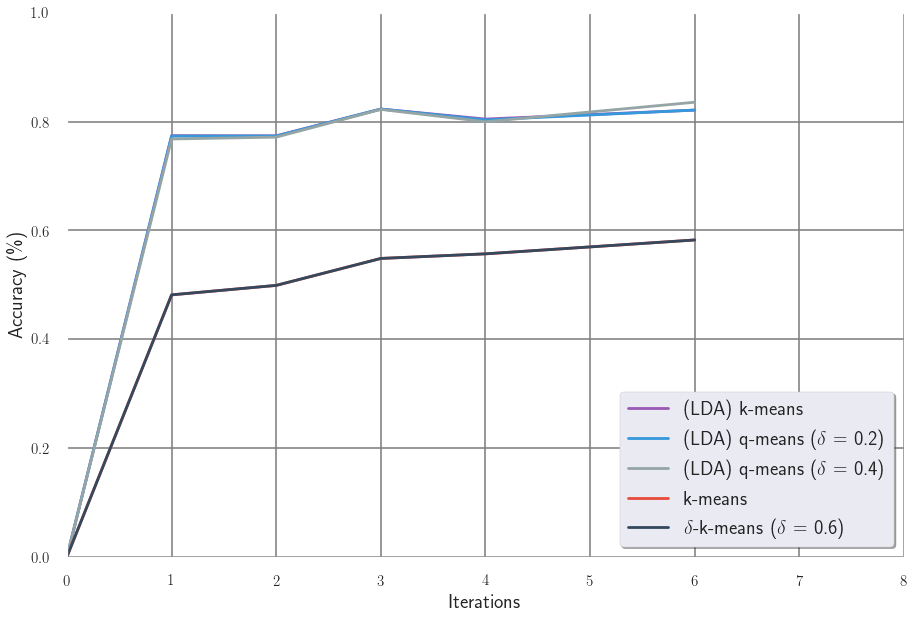

In [10]:
import matplotlib.lines as mlines
plt.style.use("seaborn-poster")
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index
#iterations_set = [0,2,3,4,5,6,7,8,9]

plot_k = ax.plot(iterations_set,results_kmeans,'#9b59b6', label="(DR) k-means")
plot_d = ax.plot(iterations_set,results_dmeans,'#3498db', label="(DR) q-means ($\delta$ = {})".format(delta))
plot_d_2 = ax.plot(iterations_set,results_dmeans_2,'#95a5a6', label="(DR) q-means ($\delta$ = {})".format(delta_2))
plot_k_non_dr = ax.plot(iterations_set,results_kmeans_original,'#e74c3c', label="k-means")
tplot_d_non_dr = ax.plot(iterations_set,results_dmeans_original,'#34495e', label="$\delta$-k-means ($\delta$ = {})".format(delta_original))


ax.set_facecolor('xkcd:white')
ax.grid(which='both', color="grey")

plt.xlabel('Iterations ', fontsize=20)
plt.ylabel('Accuracy (\%)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(0, 8)
plt.ylim(0, 1)
plt.grid(True)

plt.legend(loc='lower right', ncol=1, shadow=True, fancybox=True, prop={'size': 20}) #, labels=['kmeans', 'dmeans'])